In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torch.utils as utils
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as dsets
from torch.utils.data import Dataset,DataLoader
from torchvision import models

import cv2

import matplotlib.pyplot as plt

import os
os.chdir("/juhyeong/projects/2019연구학점제/")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import time
import copy
import random as rd

device = torch.device('cuda')

In [3]:
batch_size_train = 256
batch_size_test = 256

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../../data/MNIST/', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../../data/MNIST/', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), batch_size=batch_size_test, shuffle=True)

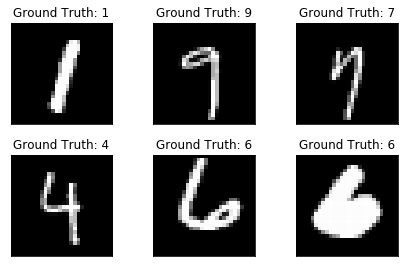

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [5]:
class flatten(nn.Module):
    def __init__(self):
        super(flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)
    
class flatten_concat(nn.Module):
    def __init__(self):
        super(flatten_concat, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return torch.mean(x.view(-1, shape), 0).unsqueeze(0)
    
class sampler_net(nn.Module):
    def __init__(self, num_params):
        super(sampler_net, self).__init__()
        self.kernel_size = (3, 3)
        self.num_params = num_params
        self.encoder = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(1, 4, kernel_size = self.kernel_size, padding = tuple(x//2 for x in self.kernel_size), stride = (2, 2)),
            nn.MaxPool2d((2,2)),
            
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size = self.kernel_size, padding = tuple(x//2 for x in self.kernel_size), stride = (2, 2)),
            nn.MaxPool2d((2,2)),

            flatten_concat()
        )
        
        self.mean = nn.Sequential(
            nn.Linear(32, self.num_params),
        )
        
        self.std = nn.Sequential(
            nn.Linear(32, self.num_params),
        )

        self.sample_dist = torch.distributions.MultivariateNormal(torch.zeros(self.num_params), torch.eye(self.num_params))
    
    def forward(self, x):
        x = self.encoder(x)
        mean = self.mean(x)
        logvar = self.std(x)
        return (mean + (self.sample_dist.sample().cuda() * (0.5 * logvar).exp())).squeeze(), mean, logvar

    
class sample_net(nn.Module):
    def __init__(self):
        super(sample_net, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size = (3, 3), padding = (1, 1), stride = (2,2)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            
            nn.Conv2d(4, 8, kernel_size = (3, 3), padding = (1, 1), stride = (2,2)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            
            flatten(),
            
            nn.Linear(2 * 2 * 8, 10, bias = True),
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def set_params(self, params):
        params = params
        param_count = 0
        self.layers[0].weight = torch.nn.Parameter(params[param_count:param_count + self.layers[0].weight.numel()].view(self.layers[0].weight.size()))
        param_count += self.layers[0].weight.numel()
        self.layers[0].bias = torch.nn.Parameter(params[param_count:param_count + self.layers[0].bias.numel()].view(self.layers[0].bias.size()))
        param_count += self.layers[0].bias.numel()
        self.layers[3].weight = torch.nn.Parameter(params[param_count:param_count + self.layers[3].weight.numel()].view(self.layers[3].weight.size()))
        param_count += self.layers[3].weight.numel()
        self.layers[3].bias = torch.nn.Parameter(params[param_count:param_count + self.layers[3].bias.numel()].view(self.layers[3].bias.size()))
        param_count += self.layers[3].bias.numel()
        self.layers[7].weight = torch.nn.Parameter(params[param_count:param_count + self.layers[7].weight.numel()].view(self.layers[7].weight.size()))
        param_count += self.layers[7].weight.numel()
        self.layers[7].bias = torch.nn.Parameter(params[param_count:param_count + self.layers[7].bias.numel()].view(self.layers[7].bias.size()))
        param_count += self.layers[7].bias.numel()

In [6]:
sample = sample_net().cuda()
print([p.numel() for p in sample.parameters() if p.requires_grad])
print(sum(p.numel() for p in sample.parameters() if p.requires_grad))

sampler = sampler_net(sum(p.numel() for p in sample.parameters() if p.requires_grad)).cuda()
print([p.numel() for p in sampler.parameters() if p.requires_grad])
print(sum(p.numel() for p in sampler.parameters() if p.requires_grad))

[36, 4, 288, 8, 320, 10]
666
[1, 1, 36, 4, 4, 4, 288, 8, 21312, 666, 21312, 666]
44302


<h1>Training</h1>

In [7]:
epoch = 1000
lr = 3e-4
optimizer_sample = torch.optim.Adam(sample.parameters(), lr = lr)
optimizer_sampler = torch.optim.Adam(sampler.parameters(), lr = lr)

In [8]:
sample = sample_net().cuda()
sampler = sampler_net(sum(p.numel() for p in sample.parameters() if p.requires_grad)).cuda()

In [9]:
CE_loss = nn.CrossEntropyLoss()
def multi_crit(output, label, mean, logvar):
    loss = 0.0
    loss += CE_loss(output, label)
    loss += -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return loss
criterion = multi_crit

In [10]:
running_test_loss = 0.0
for run in range(epoch):
    start = time.time()
    
    #Training
    sampler.train()
    sample.train()
    train_loss = 0.0
    for ind, data in enumerate(train_loader):
        optimizer_sampler.zero_grad()
        img, label = data
        params, mean, logvar = sampler(img.cuda())
        sample.set_params(params)
        output = sample(img.cuda())
        loss = multi_crit(output, label.cuda(), mean, logvar)
        loss.backward()
        train_loss += loss
        optimizer_sampler.step()
    train_loss /= (len(train_loader) * 256)
    
    #Test
    sampler.eval()
    sample.eval()
    with torch.no_grad():
        test_loss = 0.0
        for ind, data in enumerate(test_loader):
            img, label = data
            params, mean, logvar = sampler(img.cuda())
            sample.set_params(params)
            output = sample(img.cuda())
            test_loss += multi_crit(output, label.cuda(), mean, logvar)
        test_loss /= (len(test_loader) * 256)
        running_test_loss += test_loss
    print("epoch : %d,train loss = %5.5f, test loss = %5.5f, running test loss = %5.5f, time: %.2f sec"
          %(run, train_loss, test_loss, running_test_loss/(run + 1), time.time() - start))

epoch : 0,train loss = 0.67529, test loss = 0.70752, running test loss = 0.70752, time: 24.09 sec
epoch : 1,train loss = 0.72354, test loss = 0.71731, running test loss = 0.71241, time: 24.66 sec
epoch : 2,train loss = 0.72267, test loss = 0.79448, running test loss = 0.73977, time: 21.79 sec
epoch : 3,train loss = 0.65827, test loss = 0.68218, running test loss = 0.72537, time: 18.63 sec
epoch : 4,train loss = 0.71045, test loss = 0.73679, running test loss = 0.72766, time: 18.66 sec
epoch : 5,train loss = 0.71502, test loss = 0.71827, running test loss = 0.72609, time: 15.68 sec
epoch : 6,train loss = 0.69270, test loss = 0.65385, running test loss = 0.71577, time: 15.67 sec
epoch : 7,train loss = 0.69350, test loss = 0.68593, running test loss = 0.71204, time: 21.51 sec
epoch : 8,train loss = 0.71191, test loss = 0.81930, running test loss = 0.72396, time: 24.58 sec
epoch : 9,train loss = 0.67993, test loss = 0.64129, running test loss = 0.71569, time: 24.15 sec
epoch : 10,train los